In [4]:
print("all ok")

all ok


In [1]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

import requests

# url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

# response = requests.get(url)

# if response.status_code == 200:
#     # Open a local file in binary write mode
#     with open("Chinook.db", "wb") as file:
#         # Write the content of the response (the file) to the local file
#         file.write(response.content)
#     print("File downloaded and saved as Chinook.db")
# else:
#     print(f"Failed to download the file. Status code: {response.status_code}")

In [ ]:
# from langchain_community.utilities import SQLDatabase

# db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# print(f"Dialect: {db.dialect}")
# print(f"Available tables: {db.get_usable_table_names()}")
# print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


In [3]:
from langchain_community.utilities import SQLDatabase
import os

# Build PostgreSQL URI from your env variables
pg_uri = (
    f"postgresql+psycopg2://"
    f"{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@"
    f"{os.getenv('DB_HOST', 'localhost')}:{os.getenv('DB_PORT', 5432)}/"
    f"{os.getenv('DB_NAME')}"
)

db = SQLDatabase.from_uri(pg_uri)

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run(f"SELECT * FROM {db.get_usable_table_names()[0]} LIMIT 5;")}')


Dialect: postgresql
Available tables: ['claims', 'customers', 'documents', 'policies']
Sample output: [(UUID('30f06f82-99f3-4f7b-a6f9-71fd9416abcf'), 'CLM-2024-00001', UUID('439d07e5-2e16-48c3-b5f0-f688ff09ef65'), 'submitted', 'theft', Decimal('880.44'), None, datetime.datetime(2025, 4, 3, 0, 0), datetime.datetime(2025, 4, 3, 0, 0), 'Marriage us middle her shake month ask. Drug pull center hundred question. Miss population project film.', None), (UUID('0b0dc05c-a5b6-484d-a2ab-1836a0a2ba6c'), 'CLM-2024-00002', UUID('e1b56cca-0999-44b1-95ff-7add9aac7da6'), 'under_review', 'theft', Decimal('17051.65'), None, datetime.datetime(2024, 4, 22, 0, 0), datetime.datetime(2024, 5, 18, 0, 0), 'Drug information response. Reveal suddenly issue bit whether edge.', None), (UUID('81dbd7c3-d9d2-473a-861c-0f7b2095a33f'), 'CLM-2024-00003', UUID('60d8ff80-2c6b-4a85-85ba-22d384f0c9c7'), 'closed', 'natural_disaster', Decimal('75320.63'), Decimal('47407.58'), datetime.datetime(2023, 8, 28, 0, 0), datetime.date

In [4]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [5]:
# Uncomment and run ONCE per environment if not installed
# %pip install -U langgraph langchain langchain_community langchain-openai sqlalchemy langsmith

import os
import requests

from langchain_community.utilities import SQLDatabase
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage

# Ensure your OpenAI key is set
# os.environ["OPENAI_API_KEY"] = "sk-..."  # set this or export in shell

# LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)


# ---------- Tools ----------

@tool
def sql_db_list_tables() -> str:
    """List all tables in the database."""
    tables = db.get_usable_table_names()
    return ", ".join(tables)

@tool
def sql_db_schema(tables: str) -> str:
    """
    Get schema and sample rows for specific tables.
    Input is comma-separated table names, e.g. "Album, Artist".
    """
    table_list = [t.strip() for t in tables.split(",") if t.strip()]
    return db.get_table_info(table_list)

@tool
def sql_db_query(query: str) -> str:
    """Execute a READ-ONLY SQL query and return results."""
    query_lower = query.lower().strip()
    if any(cmd in query_lower for cmd in ["insert", "update", "delete", "drop", "alter", "create"]):
        raise ValueError("Only SELECT queries allowed")
    if ";" in query and (not query.endswith(";") or query.count(";") > 1):
        print(query)
        raise ValueError("Single statement only")
    if "limit" not in query_lower:
        query += " LIMIT 5"
    return db.run(query)

@tool
def sql_db_query_checker(query: str) -> str:
    """Double check SQL query for common mistakes before execution."""
    checker_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = f"""Check this SQL query for common mistakes:
- NOT IN with NULL values
- UNION vs UNION ALL  
- BETWEEN for exclusive ranges
- Data type mismatches
- Missing LIMIT clause

Query: {query}

Respond with corrected query or 'OK' if no issues."""
    return checker_llm.invoke(prompt).content

tools = [sql_db_list_tables, sql_db_schema, sql_db_query, sql_db_query_checker]

for t in tools:
    print(f"{t.name}: {t.description}\n")

# ---------- Agent ----------

system_prompt = """
You are an agent designed to interact with a SQL database.

Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

---

**Understanding the database structure**

Before answering any user question, you MUST build a clear picture of the
database schema and relationships:

1. First, list all tables in the database so you know what entities exist.
2. For any table that might be relevant to the question, inspect its schema:
   - Column names and data types
   - Primary keys
   - Foreign keys and their referenced tables/columns
   - Any obvious relationship columns (e.g. user_id, order_id, product_id)
3. From this, form an internal understanding of:
   - What each table represents (e.g. users, orders, products)
   - How tables are connected (one-to-many, many-to-many, etc.)
   - Which columns should be used for joins between tables.

If tools are available to get table info or metadata (such as table schemas,
primary keys, foreign keys, indexes, or constraints), you MUST use them before
writing complex queries, especially when joins are needed.

---

**Working with joins and relationships**

When fetching data that spans multiple tables:

- Prefer explicit JOINs using discovered foreign key relationships.
- Avoid guessing join conditions if you are unsure; instead, inspect the schema
  again to confirm the correct keys.
- Only select the columns that are relevant to the user’s question.
- Use WHERE conditions and LIMIT {top_k} to keep results focused.

---

**Answering the user**

After executing the query:

- Explain in natural language how you retrieved the data (e.g. which tables and
  joins were used).
- Clearly answer the user’s question using the query results.
- When helpful, show the SQL query you used.

Always think step-by-step: 
1) understand the question, 
2) inspect the database structure (tables, columns, keys, relationships), 
3) design the query, 
4) double-check it, 
5) run it, 
6) interpret and explain the results.

""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_prompt
)

question = "Pull the customers information and policies information like policy_number, policy_type, status, premium_amount, coverage_amount, policy_type ext... of CLM-2024-00181 claim_number."
result = agent.invoke({
    "messages": [HumanMessage(content=question)]
})

print(result["messages"][-1].content)


sql_db_list_tables: List all tables in the database.

sql_db_schema: Get schema and sample rows for specific tables.
Input is comma-separated table names, e.g. "Album, Artist".

sql_db_query: Execute a READ-ONLY SQL query and return results.

sql_db_query_checker: Double check SQL query for common mistakes before execution.

I retrieved the customer and policy information related to the claim number **CLM-2024-00181** by joining the `claims`, `policies`, and `customers` tables. The relevant columns selected include customer details and policy information.

Here are the details I found:

- **Customer Name**: Jonathan Evans
- **Email**: michael93@example.org
- **Phone**: 001-369-631-5727
- **Address**: 961 Sandra Isle, Nicholechester, MT, 16300
- **Policy Number**: POL-TRAVEL-10304
- **Policy Type**: travel
- **Status**: active
- **Premium Amount**: 257.07
- **Coverage Amount**: 28955.29

The SQL query used to obtain this information was:

```sql
SELECT c.first_name, c.last_name, c.email

In [6]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [7]:
from typing import List
from pydantic import BaseModel

class ClaimPolicyInfo(BaseModel):
    claim_amount: float
    policy_type: str
    premium_amount: float
    coverage_amount: float

class TopClaimsResponse(BaseModel):
    items: List[ClaimPolicyInfo]

In [8]:
import ast
import json
import re
from decimal import Decimal
from langchain_core.messages import ToolMessage, AIMessage

def format_as_json(state: MessagesState):
    """
    Take the latest sql_db_query tool result and emit a final AIMessage
    whose content is pure JSON (TopClaimsResponse).
    """
    # Find the last tool message from sql_db_query
    tool_messages = [
        m for m in state["messages"]
        if isinstance(m, ToolMessage) and m.name == "sql_db_query"
    ]
    if not tool_messages:
        payload = {"items": []}
        return {"messages": [AIMessage(content=json.dumps(payload))]}

    last_tool_msg = tool_messages[-1]
    raw = last_tool_msg.content

    # Tool output is a string like:
    # "[(Decimal('286790.08'), 'home', Decimal('897.45'), Decimal('985247.39')), ...]"
    if isinstance(raw, str):
        try:
            # First try normal literal_eval in case it's already clean
            rows = ast.literal_eval(raw)
        except Exception:
            # Strip the Decimal(...) wrapper and try again
            # Replace Decimal('123.45') -> '123.45'
            cleaned = re.sub(
                r"Decimal\('([^']*)'\)",
                r"\1",
                raw
            )
            rows = ast.literal_eval(cleaned)
    else:
        rows = raw

    items = []
    for row in rows:
        # After cleaning, row looks like:
        # ('286790.08', 'home', '897.45', '985247.39') or similar
        claim_amount, policy_type, premium_amount, coverage_amount = row

        def to_float(x):
            if isinstance(x, (float, int)):
                return float(x)
            if isinstance(x, Decimal):
                return float(x)
            # x is probably a string
            return float(str(x))

        items.append({
            "claim_amount": to_float(claim_amount),
            "policy_type": policy_type,
            "premium_amount": to_float(premium_amount),
            "coverage_amount": to_float(coverage_amount),
        })

    # Optional: validate with Pydantic (if you defined these classes)
    # resp = TopClaimsResponse(items=[ClaimPolicyInfo(**item) for item in items])
    # json_str = resp.json()

    # Or directly dump as JSON without Pydantic:
    payload = {"items": items}
    json_str = json.dumps(payload)

    # Final message: **only JSON string**
    return {"messages": [AIMessage(content=json_str)]}


In [9]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")
builder.add_node(format_as_json, "format_as_json")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "format_as_json")

agent = builder.compile()

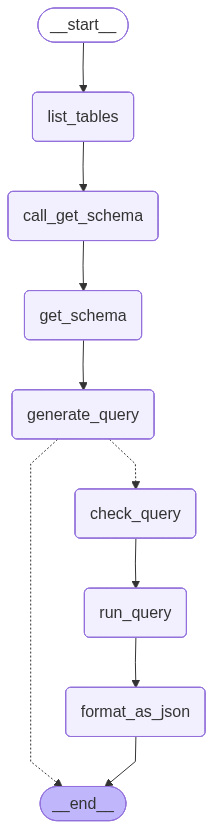

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
question = "provide me top 5 clames amounts and policy information like type of policy and policy premium_amount, coverage_amount ext... "

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

provide me top 5 clames amounts and policy information like type of policy and policy premium_amount, coverage_amount ext... 
================================== Ai Message ==================================

Available tables: claims, customers, documents, policies
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_rgsMxLvIRSBV5yRlYTFjXAQ4)
 Call ID: call_rgsMxLvIRSBV5yRlYTFjXAQ4
  Args:
    tables: claims
  sql_db_schema (call_lxyu5nRjqpoI4jkY9wqaqbtY)
 Call ID: call_lxyu5nRjqpoI4jkY9wqaqbtY
  Args:
    tables: policies
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE policies (
	id UUID NOT NULL, 
	policy_number VARCHAR(50) NOT NULL, 
	customer_id UUID NOT NULL, 
	policy_type VARCHAR(50), 
	status VARCHAR(50), 
	premium_amount NUMERIC(12, 2), 
	coverage_amount NUMERIC(14, 2),

In [12]:
final_state = None
for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    final_state = step  # overwritten until last

final_msg = final_state["messages"][-1]
# final_msg.content is a JSON string
print(final_msg.content)        # already JSON
parsed = json.loads(final_msg.content)
print(parsed["items"][0])


{"items": [{"claim_amount": 286790.08, "policy_type": "home", "premium_amount": 897.45, "coverage_amount": 985247.39}, {"claim_amount": 286476.82, "policy_type": "home", "premium_amount": 1634.8, "coverage_amount": 990571.02}, {"claim_amount": 277904.43, "policy_type": "home", "premium_amount": 1986.7, "coverage_amount": 974340.62}, {"claim_amount": 277176.47, "policy_type": "home", "premium_amount": 897.45, "coverage_amount": 985247.39}, {"claim_amount": 272555.08, "policy_type": "home", "premium_amount": 1634.8, "coverage_amount": 990571.02}]}
{'claim_amount': 286790.08, 'policy_type': 'home', 'premium_amount': 897.45, 'coverage_amount': 985247.39}


In [13]:
#%pip install -U fastapi
from fastapi import FastAPI, HTTPException
from fastapi.responses import JSONResponse
import json

app = FastAPI()


In [14]:
async def run_claim_query(question: str):
    final_state = None

    for step in agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values",
    ):
        final_state = step

    if final_state is None:
        raise ValueError("No result from agent")

    final_msg = final_state["messages"][-1]
    raw_json = final_msg.content

    # Validate JSON
    try:
        data = json.loads(raw_json)
        return data
    except json.JSONDecodeError:
        raise ValueError(f"Invalid JSON from agent: {raw_json}")


In [15]:
@app.get("/top-claims")
async def get_top_claims():
    try:
        data = await run_claim_query(
            "provide me top 5 clames amounts and policy information like type of policy and policy premium_amount, coverage_amount ext..."
        )
        return JSONResponse(content=data, status_code=200)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))
